In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np 
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import random 

# 데이터 확인

In [ ]:
# 한 개의 json 불러와서 간단하게 구조 확인
df_json = pd.read_json('/content/gdrive/Shareddrives/경진대회/Combined_LabelledData_452_유효전력평균.json')
df_json.head()

,SVC_NAME,BASE_ITEM,DEVICE_ID,DEVICE_BD_ID,COMPANY_NAME,ESTABLISH_YEAR,LOCATION,COMPANY_TYPE,COMPANY_CAT,MAJOR_PRODUCT,CONTRACT_POWER,BILL_OPTION,KEPCO_INFO,facility_name,facility_type_name,facility_vendor,facility_year,facility_capacity,facility_volt,data
0,기동패턴,유효전력평균,6521,1,CO-322,1998,대구 달서구,제조,직물,원단,900,산업용(을)고압A 선택II,05-****-****,B동 드라이기,보일러,신일,2006,19,380,"{'ITEM_NAME': '누적전력량', 'ITEM_VALUE': 3586.3078..."
1,기동패턴,유효전력평균,6521,1,CO-322,1998,대구 달서구,제조,직물,원단,900,산업용(을)고압A 선택II,05-****-****,B동 드라이기,보일러,신일,2006,19,380,"{'ITEM_NAME': '온도', 'ITEM_VALUE': 33.125, 'TIM..."
2,기동패턴,유효전력평균,6521,1,CO-322,1998,대구 달서구,제조,직물,원단,900,산업용(을)고압A 선택II,05-****-****,B동 드라이기,보일러,신일,2006,19,380,"{'ITEM_NAME': '상전압평균', 'ITEM_VALUE': 232.83332..."
3,기동패턴,유효전력평균,6521,1,CO-322,1998,대구 달서구,제조,직물,원단,900,산업용(을)고압A 선택II,05-****-****,B동 드라이기,보일러,신일,2006,19,380,"{'ITEM_NAME': '선간전압평균', 'ITEM_VALUE': 402.9166..."
4,기동패턴,유효전력평균,6521,1,CO-322,1998,대구 달서구,제조,직물,원단,900,산업용(을)고압A 선택II,05-****-****,B동 드라이기,보일러,신일,2006,19,380,"{'ITEM_NAME': '전압고조파평균', 'ITEM_VALUE': 2.31119..."


In [ ]:
# 유효전력평균 값과 timestamp 값만 추출하는 함수
def extract_data(data_array, target_name ='유효전력평균'):
    target_value = []
    target_time_stamp = []
    for data in data_array: 
        if data['ITEM_NAME'] == target_name :
            target_value.append(data['ITEM_VALUE'])
            target_time_stamp.append(data['TIMESTAMP'])
    print(f'found {len(target_value)} object in target_value')
    print(f'found {len(target_time_stamp)} object in target_time_stamp')
    df = pd.DataFrame(target_value, target_time_stamp, columns=[target_name])
    return df

# 모든 json 파일에서 유효전력값과 timestamp만 추출하여 하나의 dataframe으로 결합
path = '/보일러/기동패턴/유효전력평균/'
json_list = os.listdir(path)

count = 0
for i in json_list:
    data_json = pd.read_json(path+i)
    data_array = data_json['data'].values
    if count == 0:
        df = extract_data(data_array)
    else:
        df = df.append(extract_data(data_array))
    count += 1

# 하루에 1440개의 데이터가 존재하는 날만 추출. 즉 결측치 있는 날은 모두 제거.
date_list = [i.split()[0] for i in df.index]
df['a'] = date_list
count = 0
for i in list(set(date_list)):
    if len(df[df.a == i]) == 1440:
        if count == 0:
            real_df = df[df.a == i]
            count += 1
        else:
            real_df = real_df.append(df[df.a == i])
      
# with open('/savepath/watt.pickle', 'wb') as f:
#     pickle.dump(real_df, f)

In [ ]:
with open('/content/gdrive/Shareddrives/경진대회/유효전력평균/watt.pickle', 'rb') as f:
    df = pickle.load(f)

del_list = ['2020-10-25', '2020-11-01', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-08', '2020-11-12'] # 하루종일 demand가 0인 날 제외
for i in del_list:
    del_index = df[df.a == i].index
    df.drop(del_index, inplace=True)

del df['a'] # 필요없는 column 제거

In [ ]:
# 그래프를 그리기 위한 전처리
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.reset_index(inplace=True)
df.columns = ['date','value']
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df = df.set_index('date')
df.head()

In [ ]:
# 10월 데이터의 그래프
plt.style.use('seaborn-whitegrid')
for day in df[df['month'] == 10]['day'].unique():
    df_target=df[(df['month'] == 10) & (df['day'] == day)]
    average = [np.average(df_target['value'].values) for i in range(len(df_target))]
    plt.figure(figsize=(30,5))
    plt.plot(np.arange(0, 24, 1/60.),  np.array(df_target['value'])/1000) # w를 kw로 변환해주기 위해 / 1000
    plt.plot(np.arange(0, 24, 1/60.),  np.array(average)/1000, label='average in days')
    plt.title(f'Time series for {10}/{day} ')
    plt.xlabel('Time(hour)')
    plt.ylabel('Value(kw)')
    plt.grid(True)
    plt.legend()
    plt.show()

# LSTM

## 전처리

In [ ]:
# min-max scailing
result = df[df['month'] == 10].copy()
result.value = result.value / 1000.
maximum = result['value'].max()
minimum = result['value'].min()
result.value = (result.value - minimum) / (maximum - minimum)

In [ ]:
# time series 데이터를 학습하기 위한 window slicing
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > (len(sequence) - 3): # 현재 시점으로부터 미래의 3개값을 예측 
            break
        seq_x = sequence['value'].values[i:end_idx]
        seq_y = sequence['value'].values[end_idx:end_idx+3]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

x, y = split_sequence(result, n_steps=15)
x = x[:, :, np.newaxis] #LSTM을 돌리기 위한 처리

In [ ]:
print(f'x shape {x.shape}')
print(f'y shape {y.shape}')

In [ ]:
x_train, x_val, y_train, y_val = x[:int(len(x)*.8)], x[int(len(x)*.8):], y[:int(len(x)*.8)], y[int(len(x)*.8):] # train, val split

## 모델 학습

In [ ]:
def build_rnn_model():
  model = keras.Sequential()
  model.add(layers.LSTM(64, return_sequences=True))
  model.add(layers.LSTM(128, return_sequences=False))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(3))
  return model

In [ ]:
model = build_rnn_model()
model.compile(loss='MeanSquaredError',optimizer='adam')
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val))

In [ ]:
# 결과 확인
y_pred = model.predict(x_val)

y_val2 = [i[0] for i in y_val] # 실제 값
y_pred2 = [i[0] for i in y_pred] # 바로 다음시점의 예측값

In [ ]:
plt.figure(figsize=(40,20))
plt.plot(range(len(y_val)), y_val2, label='true')
plt.plot(range(len(y_val)), y_pred2, label='pred')
plt.legend()
plt.show()

# 강화학습

In [ ]:
# 강화학습을 위한 데이터 전처리
y_pred = model.predict(x)
real_input = []
count = 0
for i in x:
    real_input.append(np.concatenate((np.array(i[-1]), np.clip(y_pred[count], 0, 100))))
    count += 1
real_input = np.array(real_input)

In [ ]:
# rescaling
for i in range(len(real_input)):
  for j in range(len(real_input[i])):
    if real_input[i][j] < 0.01: # 0과 가까운 예측값들 다 0으로 수정
      real_input[i][j] = 0

real_input2 = real_input * (maximum - minimum) + minimum 
real_input2

# with open("/content/gdrive/Shareddrives/경진대회/유효전력평균/real_input2_rnn.pickle", "wb") as fr: # recovery value
#     pickle.dump(real_input2_rnn, fr)
# with open("/content/gdrive/Shareddrives/경진대회/유효전력평균/real_input_rnn.pickle", "wb") as fr: # min-max scailng value
#     pickle.dump(real_input_rnn, fr)

In [ ]:
# Load pickle rnn's output
with open("/content/gdrive/Shareddrives/경진대회/유효전력평균/real_input2_rnn.pickle","rb") as fr: # recovery value
    data2 = pickle.load(fr)
with open("/content/gdrive/Shareddrives/경진대회/유효전력평균/real_input_rnn.pickle","rb") as fr: # min-max scailng value
    data = pickle.load(fr)

In [ ]:
class Simul(object):
    def __init__(self, init_battery_price=500000, init_battery_capacity=50, max_battery_capacity=100):
        self.init_unit_battery_price = 100000 #  Assume that 100 $ / 1kw capacity  
        self.init_battery_capacity = init_battery_capacity 
        self.init_battery_price = self.init_battery_capacity * self.init_unit_battery_price
        self.max_battery_capacity = max_battery_capacity
 
        self.current_battery_price = init_battery_price
        self.current_battery_capacity = init_battery_capacity 
        self.korean_tou = pd.read_csv("/content/gdrive/Shareddrives/경진대회/BEAR/tou_table.csv")
        self.current_hour = 0
        self.current_min = 14 # rnn의 step이 15이므로

    def calculate_bill_cost(self, amount):
        unit_price = self.korean_tou.loc[self.current_hour,'rate'] 
        return - unit_price*amount

    def calculate_tou_rate(self) :
        unit_price_t = self.korean_tou.loc[self.current_hour, 'rate']
 
        hour = self.current_hour 
        min_t_1 = self.current_min+1
        
        if min_t_1 == 60:
            hour += 1   
            min_t_1 =0

        if hour == 24: 
            hour = 0 

        unit_price_t_1 = self.korean_tou.loc[hour, 'rate']

        min_t_2 = min_t_1+1
        if min_t_2 == 60:
            hour += 1     
            min_t_2 =0 

        if hour == 24: 
            hour = 0 

        unit_price_t_2 = self.korean_tou.loc[hour, 'rate']
 
        min_t_3 = min_t_2+1
        if min_t_3 == 60:
            hour += 1 
            min_t_3 = 0

        if hour == 24: 
            hour = 0 
 
        unit_price_t_3 = self.korean_tou.loc[hour, 'rate']
 
        
        return (unit_price_t, unit_price_t_1, unit_price_t_2, unit_price_t_3)
 
    # action in [0~1] : if action is 0.1 then discharge 0.1 % of current capaicity 
    def transition(self, percentage_action, current_demand) :
        discharge_amount = percentage_action
        # means that battery can`t cover all demands  
        if discharge_amount <= current_demand :
            # so that we can buy additional electrics 
            surplus_to_buy = current_demand - discharge_amount
            cost = self.calculate_bill_cost(surplus_to_buy)
            # reset to current_battary
            self.current_battery_capacity = self.current_battery_capacity-discharge_amount
        
        # means that discharge_amount is greater than demand 
        elif discharge_amount > current_demand :
            # agent don`t have to charge over the demand, discharge all the amount he has 
            adjusted_amount = current_demand
            # doesn`t require additional cost 
            cost = 0
            self.current_battery_capacity = self.current_battery_capacity - adjusted_amount 
            
        else : raise print('exception occur!')
        
        # update simulator`s clocks 
        self.current_min += 1 
        if self.current_min == 60:
            self.current_hour+= 1 
            self.current_min = 0 

        if self.current_hour == 24 :
            charge_amount = (self.max_battery_capacity-self.current_battery_capacity) 
            self.current_battery_capacity = self.max_battery_capacity
            self.current_hour = 0 
            chargeing_cost = self.calculate_bill_cost(charge_amount)

        else : chargeing_cost = 0 

        tou_t, tou_t_1, tou_t_2, tou_t_3 = self.calculate_tou_rate()
        return np.array([self.current_hour, self.current_min, self.current_battery_capacity, tou_t, tou_t_1, tou_t_2, tou_t_3]), cost+chargeing_cost
 
    def reset(self):
        # reset state 
        self.current_battery_price = self.init_battery_price
        self.current_battery_capacity = self.init_battery_capacity
        self.current_hour = 0
        self.current_min = 14
        tou_t, tou_t_1, tou_t_2, tou_t_3 = self.calculate_tou_rate()
    
 
        return np.array([self.current_hour, self.current_min, self.current_battery_capacity, tou_t, tou_t_1, tou_t_2, tou_t_3])

In [ ]:
class Policy(nn.Module):
  def __init__(self, num_inputs=11, hidden_size=128, num_outputs=1):
    super(Policy, self).__init__()
    self.fc1 = nn.Linear(num_inputs, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 32)
    self.fc_mu = nn.Linear(32, num_outputs) # for mu 
    self.fc_sd = nn.Linear(32, num_outputs) # for sigma 
    
    torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1)
    torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1)
    
  def forward(self, inputs):
    hour, min, current_battery_capacity, tou_t, tou_t_1, tou_t_2, tou_t_3, d_1, d_2, d_3, d_4 = inputs 
    inputs = np.array([hour/24, min/60, current_battery_capacity/500, tou_t/136.4, tou_t_1/136.4, tou_t_2/136.4, tou_t_3/136.4, d_1, d_2, d_3, d_4])
    inputs = torch.tensor(inputs, dtype=torch.float)
    x = F.relu(self.fc1(inputs))
    x = F.relu(self.fc2(x))
    mu = self.fc_mu(x)
    sd = F.softplus(self.fc_sd(x)) # sd는 항상 양수
    return mu, sd

In [ ]:
class Value(nn.Module):
  def __init__(self, num_inputs=11, hidden_size=128, num_outputs=1):
    super(Value, self).__init__()
    self.fc1 = nn.Linear(num_inputs, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 32)
    self.fc3 = nn.Linear(32, num_outputs)
    
    torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1)
    torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1)

  def forward(self, inputs):
    hour, min, current_battery_capacity, tou_t, tou_t_1, tou_t_2, tou_t_3, d_1, d_2, d_3, d_4 = inputs 
    inputs = np.array([hour/24, min/60, current_battery_capacity/500, tou_t/136.4, tou_t_1/136.4, tou_t_2/136.4, tou_t_3/136.4, d_1, d_2, d_3, d_4])
    inputs = torch.tensor(inputs, dtype=torch.float)
    x = F.relu(self.fc1(inputs))
    x = F.relu(self.fc2(x))
    value = self.fc3(x)
    return value

In [ ]:
class Agent(object):
    def __init__(self, input_dims, gamma, actor_lr, critic_lr, hidden_size, num_outputs) : 
        self.log_probs = None 
        self.entropy = None
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr 
        self.input_dims = input_dims
        self.hidden_size = hidden_size
 
        ## define actor & critic network 
        self.actor = Policy(num_inputs = input_dims, hidden_size = hidden_size, num_outputs = 1)
        self.critic = Value(num_inputs = input_dims, hidden_size = hidden_size, num_outputs = 1)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr) 
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr) 
 
    def select_action(self, state):
        hour, min, current_battery_capacity, tou_t, tou_t_1, tou_t_2, tou_t_3, d_1, d_2, d_3, d_4 = state
        state = torch.tensor(state, dtype=torch.float)

        mu,sd = self.actor(state)
        normal = Normal(mu,sd)
        action = normal.sample()
        self.log_probs = normal.log_prob(action)
        action = torch.clamp(min=0, max=current_battery_capacity, input=action) # 0 <= action <= current_battery_capacity
        self.entropy = normal.entropy().sum()
        return action.item()
 
    def Actor_Critic_train(self, state, reward, state_prime):
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
 
        reward = torch.tensor(reward, dtype= torch.float)*0.00000001 # reward scaling ratio 0.00000001
        v_prime = self.critic(state_prime)
        v_current= self.critic(state)
        td_target = reward + self.gamma * v_prime 
 
        # unbias estimate for advantage function A = Q-V  
        td_error = td_target - v_current # td error = r+gamma V(s_{t+1}) -Vs(t)
        actor_loss = -self.log_probs*td_error # J_theta = log pi * \delta(td error)
        critic_loss = (td_error**2)  # same as Temperal diffrence learning in previous lecture
        entropy_loss = 0.0001*self.entropy
        loss = actor_loss + critic_loss - entropy_loss
        loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [ ]:
# hyper parameter setting
hidden_size = 32
actor_lr = 0.001
critic_lr = 0.001
gamma = 0.9 # discount factor
charge_num = 0
discharge_num = 0
  
# build environment
env = Simul(init_battery_capacity=500, max_battery_capacity=500)
agent = Agent(gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, input_dims=11, hidden_size=hidden_size, num_outputs=1)
 
log  = []
cap = [] 
total_cost = []
buy_all_lst = [] 
training_num = 0
 
print(f"##################### if buy all demand cost:{-1366723.9117500002} ##########################")
 
for n_epi in range(100000):
    state = env.reset()
    state = np.concatenate((state, data[0]))
    for time in range(len(data)-1):
        percentage_action = agent.select_action(state = torch.from_numpy(state).float())
        real_usage = data2[time][0]   
        next_state, cost = env.transition(percentage_action, current_demand=real_usage)
        next_state = np.concatenate((next_state, data[time+1]))

        if (n_epi != 0):
            agent.Actor_Critic_train(state, cost, next_state)
            training_num+=1
        
        # if random.random() < 0.8:
        #     agent.Actor_Critic_train(state, cost, next_state)
        #     training_num+=1
        
        state = next_state
        cap.append(env.current_battery_capacity)
        total_cost.append(cost)
    
    print(f"# episode {n_epi}, cost : {np.sum(total_cost)}, average_capacity :{np.mean(cap):.2f}, training_num:{training_num}")
    log.append(np.sum(total_cost))
    if np.sum(total_cost) >= -1140000:
      torch.save(agent.actor.state_dict(), '/content/gdrive/Shareddrives/경진대회/유효전력평균/113500.pth')
      break
    total_cost=[]
    buy_all_lst = []
    cap = []

##################### if buy all demand  cost :-1366723.9117500002:##########################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# episode 0, cost : -1336239.2573247731, average_capacity :468.41, training_num:8072
# episode 1, cost : -1327211.514655586, average_capacity :460.53, training_num:16107
# episode 2, cost : -1234615.1955891312, average_capacity :384.18, training_num:24157
# episode 3, cost : -1248039.729283386, average_capacity :383.17, training_num:32164
# episode 4, cost : -1164001.1080498493, average_capacity :306.61, training_num:40175
# episode 5, cost : -1153399.3436282137, average_capacity :233.27, training_num:48156
# episode 6, cost : -1149314.949326233, average_capacity :226.62, training_num:56205
# episode 7, cost : -1162122.8374741513, average_capacity :216.50, training_num:64198
# episode 8, cost : -1154926.6731921972, average_capacity :221.09, training_num:72299
# episode 9, cost : -1148558.5836389419, average_capacity :224.39, training_num:80389
# episode 10, cost : -1166684.0270152383, average_capacity :215.44, training_num:88467
# episode 11, cost : -1164539.2307436105, average_capacit

KeyboardInterrupt: ignored

In [ ]:
# 1238338.2043250003 greedy case's cost

# greedy하게 사용했을 때 cost 계산
"""
korean_tou = pd.read_csv("/content/gdrive/Shareddrives/경진대회/BEAR/tou_table.csv")
hour = 0
min = 14
sum = 0
count = 0
day = 14

for i in range(len(data2)-1):
  if min == 60:
    hour += 1 
    min = 0
  if hour == 24:
    hour = 0
  if day == 1440:
    count = 0
    day = 0
  amount = data2[i][0]
  if count <= 0:
    sum += korean_tou.loc[hour, 'rate'] * amount
  count -= amount
  day += 1
  min += 1
sum + 62.7*3500 # 전기세 + 배터리 충전비용
"""

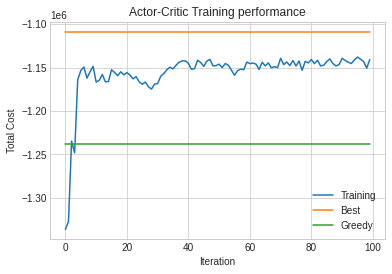

In [ ]:
# one = np.repeat(-1108773.9117500002, len(log)) # best case
# two = np.repeat(-1238338.2043250003, len(log)) # greedy case

# plt.style.use('seaborn-whitegrid')
# plt.plot(log, label='Training')
# plt.plot(one, label='Best')
# plt.plot(two, label='Greedy')
# plt.title("Actor-Critic Training performance")
# plt.xlabel("Iteration")
# plt.ylabel("Total Cost")
# plt.legend()
# plt.grid(True)

In [ ]:
# test

hidden_size = 32
actor_lr = 0.001
critic_lr = 0.001
gamma = 0.9

env = Simul(init_battery_capacity=500, max_battery_capacity=500)
agent = Agent(gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, input_dims=11, hidden_size=hidden_size, num_outputs=1)
agent.actor.load_state_dict(torch.load('/content/gdrive/Shareddrives/경진대회/유효전력평균/113-.pth')) # load actor

log  = []
cap = [] 
total_cost = []
buy_all_lst = [] 
training_num = 0
 
print(f"##################### if buy all demand cost :{-1366723.9117500002} ##########################")
 
action = [] 

for n_epi in range(1):
    state = env.reset()
    state = np.concatenate((state, data[0]))
    for time in range(len(data)-1):
        
        state_t_cap = env.current_battery_capacity
        percentage_action = agent.select_action(state = torch.from_numpy(state).float())
        real_usage = data2[time][0]  
        next_state, cost = env.transition( percentage_action, current_demand=real_usage)
        state_t_1_cap = env.current_battery_capacity
        action.append(state_t_cap - state_t_1_cap)
        next_state = np.concatenate((next_state, data[time+1]))
        state = next_state
        cap.append(env.current_battery_capacity)
        total_cost.append(cost)
        
 
    
    print(f"# episode {n_epi}, cost : {np.sum(total_cost)}, average_capacity :{np.mean(cap):.2f}, training_num:{training_num}")
    log.append(np.sum(total_cost))

##################### if buy all demand  cost :-1366723.9117500002:##########################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# episode 0, cost : -1139510.854016511, average_capacity :263.74, training_num:0


In [ ]:
demand = []
for i in data2:
  demand.append(i[0])
demand.pop()

for i in range(len(action)):
  if action[i] < 0:
    action[i] = 0

time_list = np.arange(0, 24, 1/60.)

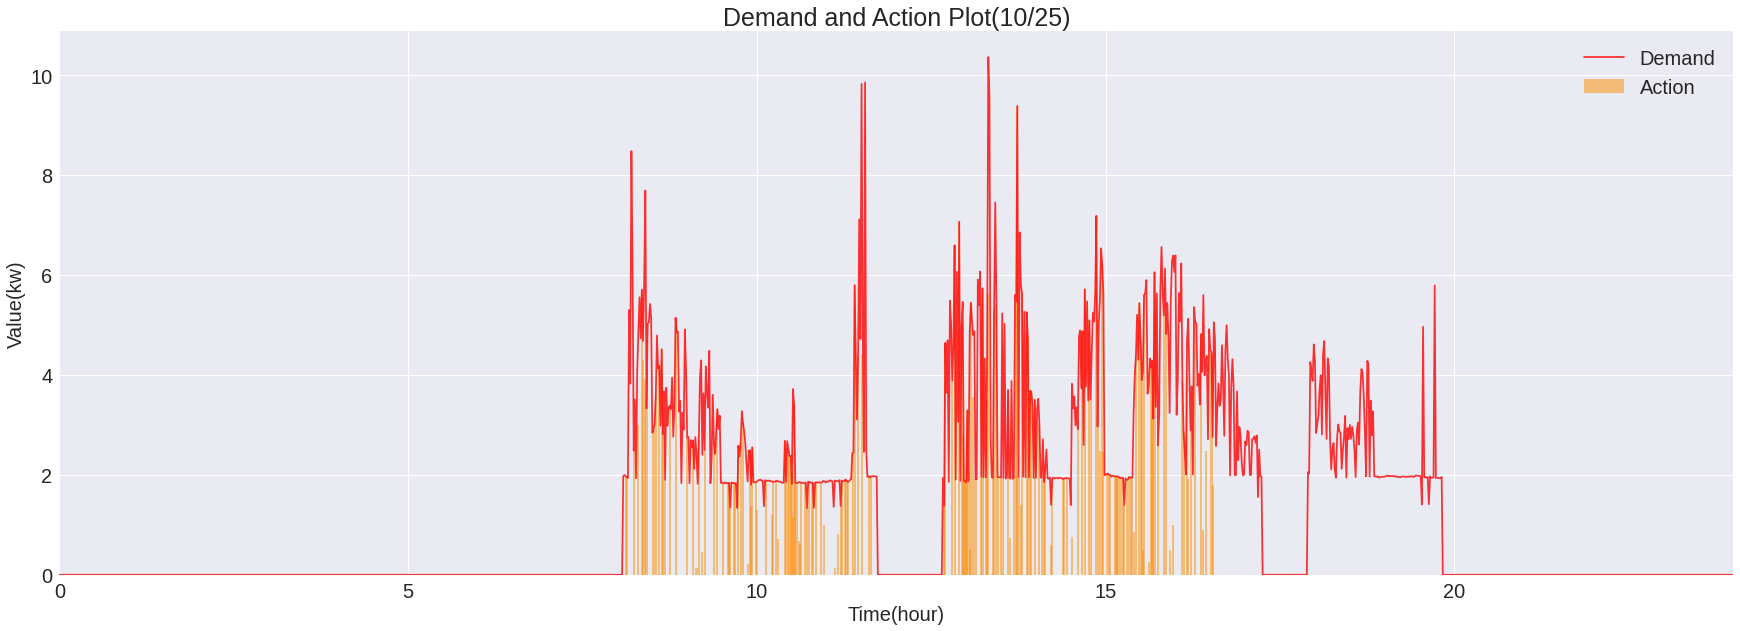

In [ ]:
# action, demand graph

plt.style.use('seaborn')
plt.figure(figsize=(30,10)) # 10/24 time_list[14:], demand[0:1426]
# 하루씩 보기
plt.plot(time_list, demand[1426+1440*0:1426+1440*1], alpha=0.8, label='Demand', color='red') 
plt.bar(time_list, action[1426+1440*0:1426+1440*1], width=0.03, alpha=0.5, label='Action', color='darkorange')
## 전체 다 보기
# plt.plot(range(len(demand)), demand, alpha=0.8, label='Demand', color='red')
# plt.plot(range(len(action)), action, alpha=0.5, label='Action', color='darkorange')
plt.title("Demand and Action Plot(10/25)",fontsize=25)
plt.xlabel("Time(hour)",fontsize=20)
plt.ylabel("Value(kw)",fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0, 24)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.plot(kind='bar')
plt.show()